In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    ProcessModelDirectives,
    RigidTransform,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    FindResourceOrThrow,
    MultibodyPlant,
    MeshcatVisualizer,
    InverseDynamicsController,
    PassThrough,
    Demultiplexer,
    StateInterpolatorWithDiscreteDerivative,
    MeshcatPoseSliders,
    ConstantVectorSource,
    JointSliders,
    Multiplexer,
    RigidTransform,
    Integrator,
    TrajectorySource,
    PiecewisePose,
    RotationMatrix,
    PiecewisePolynomial
)
import manipulation
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import ConfigureParser, RenderDiagram
from manipulation.meshcat_utils import AddMeshcatTriad

import sys

sys.path.append("../")

from src.station import  MakePandaManipulationStation
from src.diff_ik import TrajectoryPlanner, PandaDiffIKController

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [6]:
# description of robot
robot_directives = """
directives:
    - add_model:
        name: panda_arm
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda_arm::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda_arm::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
"""

# description of objects in env
env_directives = f"""
directives:
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]
    # - add_model:
    #     name: basket
    #     file: file://{os.getcwd()}/../models/basket.sdf
    #     default_free_body_pose:
    #         basket:
    #             translation: [-0.25, -0.25, 0.0]
    - add_model:
        name: foam_brick
        file: package://manipulation/hydro/061_foam_brick.sdf
        default_free_body_pose:
            base_link:
                translation: [-0.25, -0.25, 0]
"""

In [22]:
builder = DiagramBuilder()

meshcat.DeleteAddedControls()
meshcat.Delete("/X_WBGrasp")
meshcat.Delete("/X_WBPreGrasp")
meshcat.Delete("/X_WBasket")
meshcat.Delete("/X_WGinit")

# add panda manipulation station
# station is a system consisting of subsytems ie. multi body plant, scene graphs, controllers ... etc
station = MakePandaManipulationStation(
    robot_directives=robot_directives,
    env_directives=env_directives,
    meshcat=meshcat,
    time_step=1e-4
)

builder.AddSystem(station)

# 
plant = station.GetSubsystemByName("plant")
panda_arm = plant.GetModelInstanceByName("panda_arm")
panda_hand = plant.GetModelInstanceByName("panda_hand")
basket = plant.GetModelInstanceByName("foam_brick")
# basket = plant.GetModelInstanceByName("basket")
panda_gripper_body = plant.GetBodyByName("panda_link8")

panda_hand_body = plant.GetBodyByName("panda_hand")
panda_hand_frame = panda_hand_body.body_frame()
gripper_frame = panda_gripper_body.body_frame()
# basket_body = plant.GetBodyByName("basket")
basket_body = plant.GetBodyByName("base_link")
basket_frame = basket_body.body_frame()


# get initial pose of end effector
context = plant.CreateDefaultContext()
plant.SetPositions(context, panda_arm, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])

# relative transform from basket to world frame
X_WB = plant.CalcRelativeTransform(context, frame_A=plant.world_frame(), frame_B=basket_frame)
X_WG = plant.CalcRelativeTransform(context, frame_A=plant.world_frame(), frame_B=gripper_frame)
# X_WBasket = plant.EvalBodyPoseInWorld(context, plant.GetBodyByName("basket"))
X_WBasket = plant.EvalBodyPoseInWorld(context, plant.GetBodyByName("base_link"))
X_WGinit = plant.EvalBodyPoseInWorld(context, panda_hand_body)

X_BPreGrasp = RigidTransform(p=[0, -0.03, 0.3], R=RotationMatrix.MakeXRotation(np.pi))
X_WBPreGrasp = X_WB.multiply(X_BPreGrasp)

X_BGrasp = RigidTransform(p=[0, -0.03, 0.1], R=RotationMatrix.MakeXRotation(np.pi))
X_WBGrasp = X_WB.multiply(X_BGrasp)

X_WGoal = X_WG.multiply(RigidTransform(R=RotationMatrix.MakeXRotation(np.pi / 2)))


initial_pose = plant.EvalBodyPoseInWorld(context, panda_hand_body)

AddMeshcatTriad(meshcat, path="/X_WBPreGrasp", X_PT=X_WBPreGrasp)
AddMeshcatTriad(meshcat, path="/X_WBGrasp", X_PT=X_WBGrasp)
AddMeshcatTriad(meshcat, path="/X_WBasket", X_PT=X_WBasket)
AddMeshcatTriad(meshcat, path="/X_WGinit", X_PT=initial_pose)

trajectory = PiecewisePose.MakeLinear(
    times=[0, 5.0, 10.0, 13.0, 17.0, 20.0, 22.0],
    poses=[X_WGinit, X_WBPreGrasp, X_WBGrasp, X_WBGrasp, X_WBPreGrasp, X_WGinit, X_WGoal],
)
traj_V_G = trajectory.MakeDerivative()



times = [0, 8.0, 10.0]
initial_positions = np.array([0.0, 0.0])
final_positions2 = np.array([0, 0])
final_positions = np.array([-0.05, 0.05])
positions = np.column_stack([initial_positions, final_positions, final_positions2])

gripper_trajectory = PiecewisePolynomial.FirstOrderHold(
    times,
    positions
)

wsg_source = builder.AddSystem(TrajectorySource(gripper_trajectory))
builder.Connect(wsg_source.get_output_port(0), station.GetInputPort("panda_hand.position"))


diff_ik = builder.AddSystem(PandaDiffIKController(plant=plant))
diff_ik.set_name("PseudoInverseController")

integrator = builder.AddSystem(Integrator(7))
trajectory_source = builder.AddSystem(TrajectorySource(traj_V_G))


builder.Connect(trajectory_source.get_output_port(0), diff_ik.GetInputPort("spatial_velocity"))
builder.Connect(station.GetOutputPort("panda_arm.position_estimated"), diff_ik.GetInputPort("q"))

builder.Connect(diff_ik.get_output_port(0), integrator.get_input_port(0))
builder.Connect(integrator.get_output_port(0), station.GetInputPort("panda_arm.position"))

diagram = builder.Build()
diagram.set_name("PandaFunzo")

context = diagram.CreateDefaultContext()
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context), 
    plant.GetPositions(plant.GetMyContextFromRoot(context), panda_arm)
)


meshcat.StartRecording()
simulator.AdvanceTo(trajectory.end_time())
meshcat.PublishRecording()

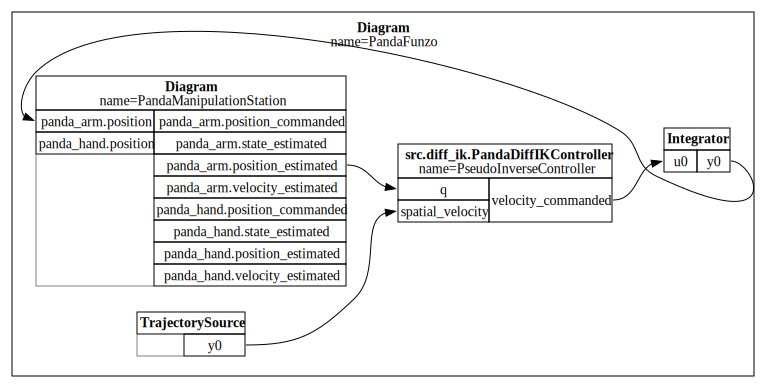

In [24]:
RenderDiagram(diagram, max_depth=1)